# **Differentiated Thyroid Cancer (DTC) Recurrence**

<h2><b>Table of Contents</b></h2>

<ol>
    <li><b>Exploratory Data Analysis</b>
        <ol style="list-style-type: none;">
            <li>1.1 Load Data</li>
            <li>1.2 Tables</li>
            <li>1.3 Figures</li>
        </ol>
    </li>
    <li><b>Feature Engineering</b></li>
    <li><b>Data Preprocessing</b></li>
    <li><b>k-Means Algorithm</b>
        <ol style="list-style-type: none;">
            <li>4.1 Elbow Method</li>
            <li>4.2 Modeling</li>
        </ol>
    </li>
    <li><b>Cluster Characterization</b>
        <ol style="list-style-type: none;">
            <li>5.1 Identify the Most Important Features</li>
            <li>5.2 Spider Plot Using Z-scores</li>
            <li>5.3 Pairwise Comparisons</li>
        </ol>
    </li>
</ol>

**Load libraries**

In [1]:
import os
from itertools import combinations
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, zscore, kruskal
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from statsmodels.stats.multitest import multipletests
from tableone import TableOne

**Load custom plot styling**

In [2]:
plt.style.use("../config/matplotlib/stylelib/mhedas.mplstyle")

## 1. Exploratory Data Analysis

### 1.1 Load Data

In [3]:
# Load data
df = pd.read_csv("../data/thyroid_diff.csv")

# Standardize column names
df.columns = (
    df.columns.str.lower()
    .str.replace(" ", "_")
    .str.replace("hx_radiothreapy", "hx_radiotherapy")
)

# Combine smoking and hx_smoking into: Current, Former, Never
df["smoking"] = df.apply(
    lambda row: (
        "Current"
        if row.get("smoking", "No") == "Yes"
        else "Former" if row.get("hx_smoking", "No") == "Yes" else "Never"
    ),
    axis=1,
)

# Drop hx_smoking
df = df.drop("hx_smoking", axis=1)

# Save cleaned data
df.to_csv("../data/thyroid_diff_cleaned.csv", index=False)

print(df.head())

   age gender smoking hx_radiotherapy thyroid_function  \
0   27      F   Never              No        Euthyroid   
1   34      F  Former              No        Euthyroid   
2   30      F   Never              No        Euthyroid   
3   62      F   Never              No        Euthyroid   
4   62      F   Never              No        Euthyroid   

          physical_examination adenopathy       pathology     focality risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     t   n   m stage       response recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0     I      Excellent       No  
2  T1a  N0  M0     I      Excellent

### 1.2 Tables

In [4]:
# Check normality of age: Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(df["age"].dropna())

# Determine if age should be treated as non-normal
age_is_nonnormal = shapiro_p < 0.05

# Define columns to show in the table
columns_to_show = [
    "age",
    "gender",
    "smoking",
    "hx_radiotherapy",
    "thyroid_function",
    "physical_examination",
    "adenopathy",
    "pathology",
    "focality",
    "risk",
    "t",
    "n",
    "m",
    "stage",
    "response",
]

# Define categorical columns
categorical_cols = [
    "gender",
    "smoking",
    "hx_radiotherapy",
    "thyroid_function",
    "physical_examination",
    "adenopathy",
    "pathology",
    "focality",
    "risk",
    "t",
    "n",
    "m",
    "stage",
    "response",
]

# Define non-normal variables
non_normal_vars = ["age"] if age_is_nonnormal else []

# Define groupby variable
groupby_col = "recurred"

# Create the table
mytable = TableOne(
    df,
    columns=columns_to_show,
    categorical=categorical_cols,
    groupby=groupby_col,
    nonnormal=non_normal_vars,
    pval=True,
    htest_name=True,
)

print(mytable)

# Save results
os.makedirs("../results/tables", exist_ok=True)
mytable.to_csv("../results/tables/table_one.csv")

                                                        Grouped by recurred                                                                                                         
                                                                    Missing           Overall                No               Yes P-Value                                       Test
n, n (%)                                                                                  383               275               108                                                   
age, median [Q1,Q3]                                                       0  37.0 [29.0,51.0]  36.0 [28.0,46.0]  44.5 [31.8,62.0]  <0.001                             Kruskal-Wallis
gender, n (%)               F                                                      312 (81.5)        246 (89.5)         66 (61.1)  <0.001                                Chi-squared
                            M                                                       71 (18.5)  

### 1.3 Figures

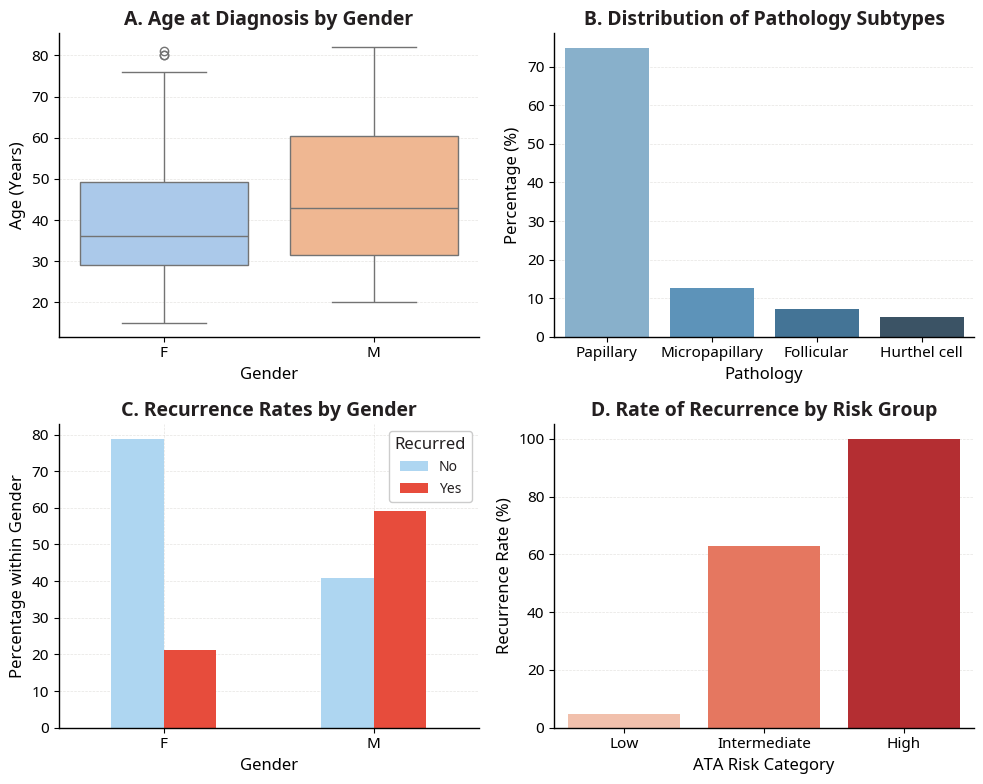

In [5]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot A: Age at Diagnosis by Gender
sns.boxplot(
    data=df,
    x="gender",
    y="age",
    hue="gender",
    palette="pastel",
    ax=axes[0, 0],
    legend=False,
)
axes[0, 0].set_title("A. Age at Diagnosis by Gender")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("Age (Years)")
axes[0, 0].set_axisbelow(True)

# Plot B: Pathology Distribution
path_counts = df["pathology"].value_counts(normalize=True) * 100
sns.barplot(
    x=path_counts.index,
    y=path_counts.values,
    hue=path_counts.index,
    palette="Blues_d",
    ax=axes[0, 1],
    legend=False,
)
axes[0, 1].set_title("B. Distribution of Pathology Subtypes")
axes[0, 1].set_ylabel("Percentage (%)")
axes[0, 1].set_xlabel("Pathology")
axes[0, 1].set_axisbelow(True)

# Plot C: Recurrence by Gender
recurrence_gender = (
    df.groupby("gender")["recurred"].value_counts(normalize=True).unstack() * 100
)
recurrence_gender.plot(
    kind="bar",
    stacked=False,
    ax=axes[1, 0],
    color=["#AED6F1", "#E74C3C"],
)
axes[1, 0].set_title("C. Recurrence Rates by Gender")
axes[1, 0].set_ylabel("Percentage within Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].legend(title="Recurred")
axes[1, 0].tick_params(axis="x", rotation=0)
axes[1, 0].set_axisbelow(True)

# Plot D: Recurrence by Risk
risk_order = ["Low", "Intermediate", "High"]
recurrence_risk = (
    df.groupby("risk")["recurred"]
    .value_counts(normalize=True)
    .unstack()
    .reindex(risk_order)
    * 100
)
sns.barplot(
    x=recurrence_risk.index,
    y=recurrence_risk["Yes"],
    hue=recurrence_risk.index,
    palette="Reds",
    ax=axes[1, 1],
    legend=False,
)
axes[1, 1].set_title("D. Rate of Recurrence by Risk Group")
axes[1, 1].set_ylabel("Recurrence Rate (%)")
axes[1, 1].set_xlabel("ATA Risk Category")
axes[1, 1].set_ylim(0, 105)
axes[1, 1].set_axisbelow(True)

# Customize and save figure
sns.despine()
plt.tight_layout()
plt.show()
os.makedirs("../results/figures", exist_ok=True)
fig.savefig("../results/figures/demographics_plots.png", dpi=300)

## 2. Feature engineering

Cramér's V values for ['t', 'n', 'm']: [np.float64(0.4250974207490025), np.float64(0.25636423870112035), np.float64(0.7550375802805919)]
Cramér's V (N vs Adenopathy): 0.6326090592074622


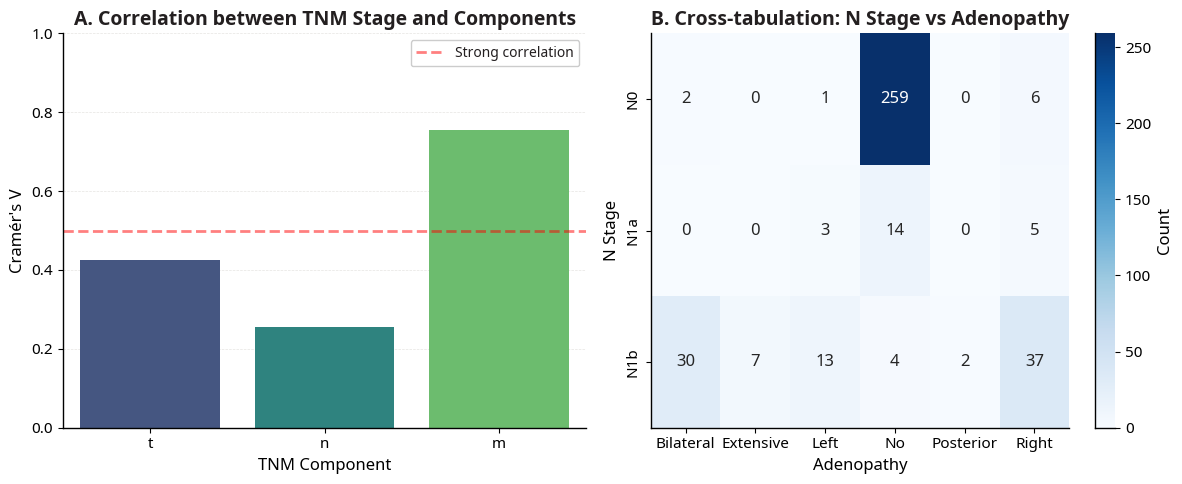

In [6]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# Plot 1: Correlation between Stage and T, N, M
stage_components = ["t", "n", "m"]
cramers_values = []

# Calculate Cramér's V for each component
for component in stage_components:
    contingency = pd.crosstab(df["stage"], df[component])
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers = np.sqrt(chi2 / (n * min_dim))
    cramers_values.append(cramers)

print(f"Cramér's V values for {stage_components}: {cramers_values}")

# Create bar plot for Cramér's V values
sns.barplot(
    x=stage_components,
    y=cramers_values,
    hue=stage_components,
    palette="viridis",
    ax=axes[0],
    legend=False,
)
axes[0].set_title("A. Correlation between TNM Stage and Components")
axes[0].set_ylabel("Cramér's V")
axes[0].set_xlabel("TNM Component")
axes[0].set_ylim(0, 1)
axes[0].axhline(
    y=0.5, color="red", linestyle="--", alpha=0.5, label="Strong correlation"
)
axes[0].legend()
axes[0].set_axisbelow(True)

# Plot 2: Correlation between N and Adenopathy
contingency_n_adenopathy = pd.crosstab(df["n"], df["adenopathy"])
chi2 = chi2_contingency(contingency_n_adenopathy)[0]
n = contingency_n_adenopathy.sum().sum()
min_dim = min(contingency_n_adenopathy.shape) - 1
cramers_n_adenopathy = np.sqrt(chi2 / (n * min_dim))

print(f"Cramér's V (N vs Adenopathy): {cramers_n_adenopathy}")

# Create a heatmap for N vs Adenopathy
sns.heatmap(
    contingency_n_adenopathy,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1],
    cbar_kws={"label": "Count"},
)
axes[1].set_title(f"B. Cross-tabulation: N Stage vs Adenopathy")
axes[1].set_ylabel("N Stage")
axes[1].set_xlabel("Adenopathy")
axes[1].set_axisbelow(True)

# Customize and save
sns.despine()
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("../results/figures/feature_correlation.png", dpi=300)

# Drop T, N, M components (keep Stage only)
df_clean = df.drop(columns=["t", "n", "m"])

## 3. Data Preprocessing

In [7]:
# Separate features and outcome
X = df_clean.drop(columns=["recurred"])
y = df_clean["recurred"]

# Define feature types
numeric_features = ["age"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Fit and transform data
X_processed = preprocessor.fit_transform(X)

## 4. *k*-Means Algorithm 

### 4.1 Elbow Method

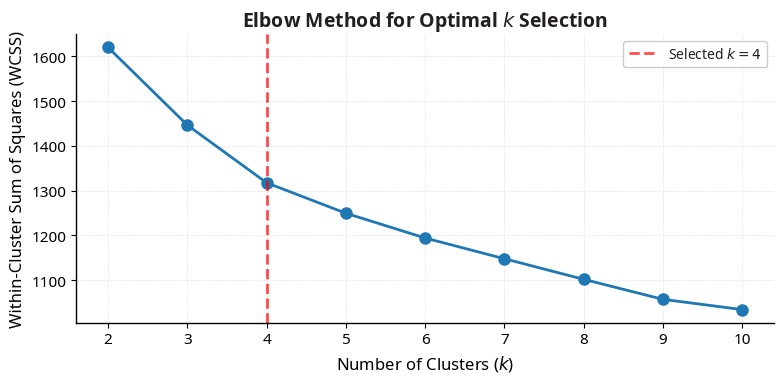

In [8]:
# Elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_processed)
    inertias.append(km.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(K_range, inertias, marker="o", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters ($k$)")
ax.set_ylabel("Within-Cluster Sum of Squares (WCSS)")
ax.set_title("Elbow Method for Optimal $k$ Selection")
ax.axvline(x=4, color="red", linestyle="--", alpha=0.7, label="Selected $k=4$")
ax.legend()
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("../results/figures/elbow_plot.png", dpi=300)

### 4.2 Modelling

Cluster 0: 18.0157%
Cluster 1: 22.9765%
Cluster 2: 14.8825%
Cluster 3: 44.1253%


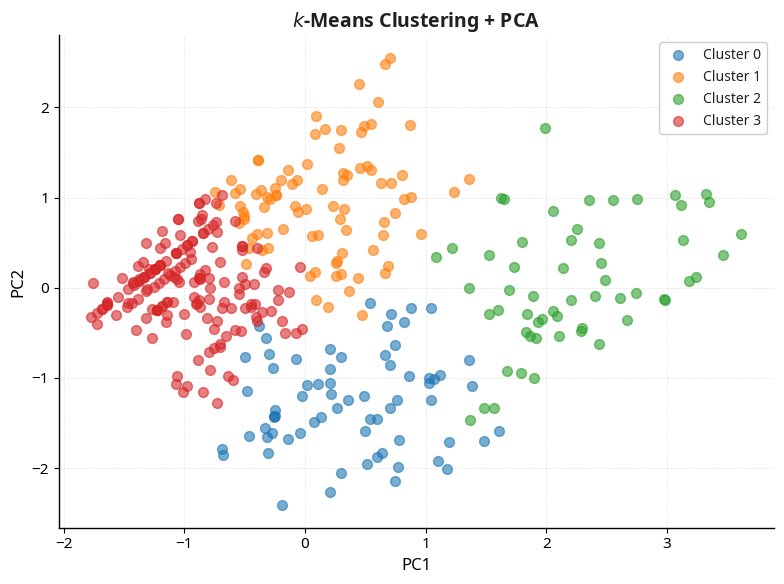

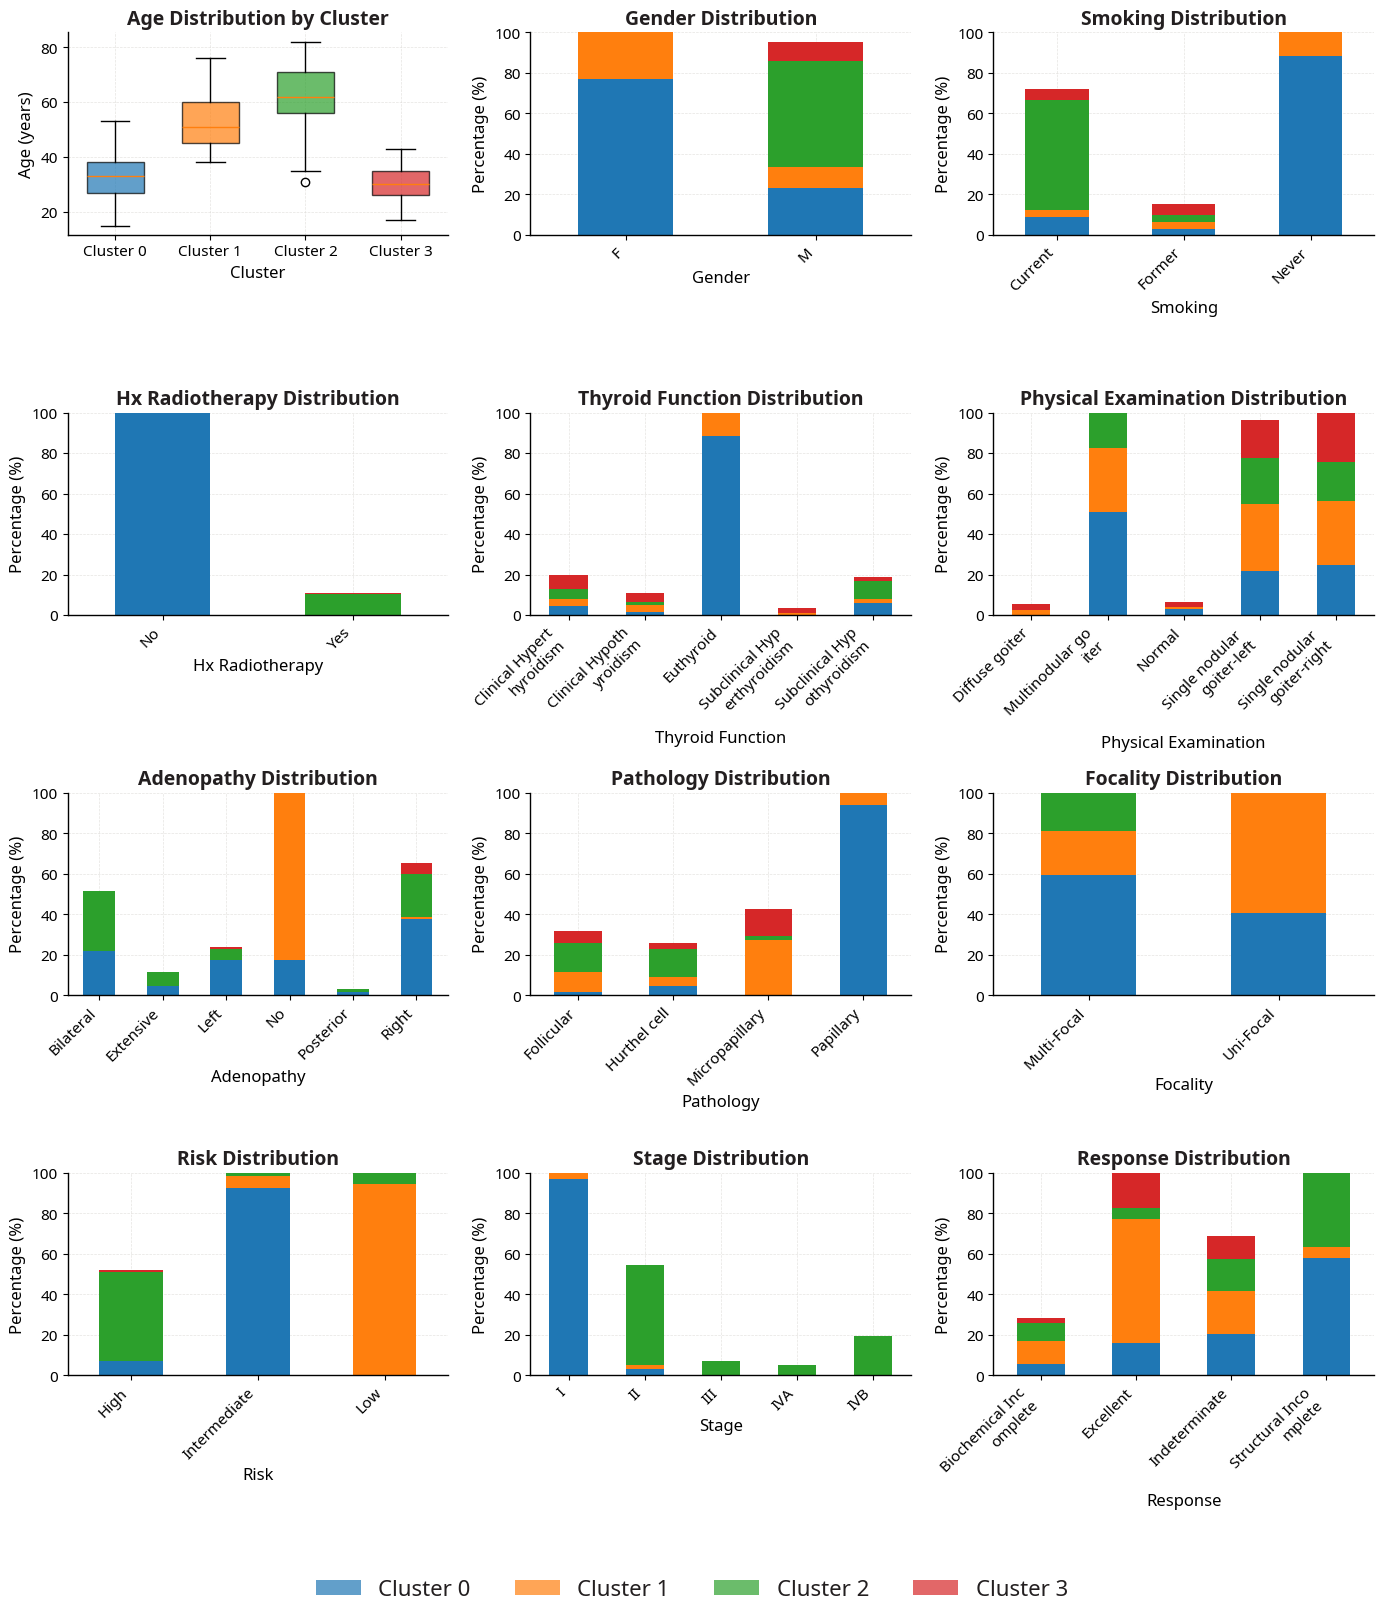

                         age          gender              smoking  \
Cluster 0  33.0 [27.0, 38.0]   F: 53 (76.8%)    Never: 61 (88.4%)   
Cluster 1  51.0 [45.0, 60.0]   F: 79 (89.8%)    Never: 82 (93.2%)   
Cluster 2  62.0 [56.0, 71.0]   M: 30 (52.6%)  Current: 31 (54.4%)   
Cluster 3  30.0 [26.0, 35.0]  F: 153 (90.5%)   Never: 151 (89.3%)   

           hx_radiotherapy        thyroid_function  \
Cluster 0  No: 69 (100.0%)   Euthyroid: 61 (88.4%)   
Cluster 1  No: 88 (100.0%)   Euthyroid: 79 (89.8%)   
Cluster 2   No: 51 (89.5%)   Euthyroid: 48 (84.2%)   
Cluster 3  No: 168 (99.4%)  Euthyroid: 144 (85.2%)   

                              physical_examination         adenopathy  \
Cluster 0          Multinodular goiter: 35 (50.7%)  Right: 26 (37.7%)   
Cluster 1   Single nodular goiter-left: 29 (33.0%)     No: 87 (98.9%)   
Cluster 2          Multinodular goiter: 33 (57.9%)     No: 20 (35.1%)   
Cluster 3  Single nodular goiter-right: 84 (49.7%)    No: 158 (93.5%)   

                 

In [9]:
# Perform final k-means clustering with k=4
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_processed)

# Add cluster labels to the cleaned dataframe
df_clean["cluster"] = cluster_labels

# Cluster distribution
cluster_counts = df_clean["cluster"].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"Cluster {cluster_id}: {percentage:.4f}%")

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(
    X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed
)

# Create PCA dataframe with cluster labels
df_pca = pd.DataFrame(
    {
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "Cluster": cluster_labels,
    }
)

# Plot clusters in PCA
fig, ax = plt.subplots(figsize=(8, 6))
for cluster_id in range(4):
    cluster_data = df_pca[df_pca["Cluster"] == cluster_id]
    ax.scatter(
        cluster_data["PC1"],
        cluster_data["PC2"],
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=50,
    )
ax.set_xlabel(f"PC1")
ax.set_ylabel(f"PC2")
ax.set_title("$k$-Means Clustering + PCA")
ax.legend()
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("../results/figures/clusters_pca.png", dpi=300)

# Get all features used in clustering
all_features = [col for col in df_clean.columns if col not in ["cluster", "recurred"]]

# Remove encoded columns
all_features = [col for col in all_features if not col.endswith("_encoded")]

# Calculate grid size
n_features = len(all_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

# Define cluster colors
cluster_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Create plots for each feature
for idx, feature in enumerate(all_features):
    # Select subplot
    ax = axes[idx]

    # Plot per feature
    if feature == "age":
        # Boxplot for age
        data_for_box = [
            df_clean[df_clean["cluster"] == i]["age"].values for i in range(4)
        ]
        bp = ax.boxplot(
            data_for_box,
            tick_labels=[f"Cluster {i}" for i in range(4)],
            patch_artist=True,
            widths=0.6,
        )

        # Color the boxes
        for patch, color in zip(bp["boxes"], cluster_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # Customize plot
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Age (years)")
        ax.set_title("Age Distribution by Cluster")
    else:
        # Stacked bar plot for categorical variables
        plot_data = (
            pd.crosstab(
                df_clean["cluster"],
                df_clean[feature],
                normalize="index",
            )
            * 100
        )
        plot_data.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            legend=False,
            color=cluster_colors,
        )
        ax.set_xlabel(feature.replace("_", " ").title())
        ax.set_ylabel("Percentage (%)")
        ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
        ax.set_ylim(0, 100)

        # Make x-axis labels more readable
        labels = [label.get_text() for label in ax.get_xticklabels()]
        wrapped_labels = [
            "\n".join([labels[i][j : j + 15] for j in range(0, len(labels[i]), 15)])
            for i in range(len(labels))
        ]
        ax.set_xticklabels(wrapped_labels, rotation=45, ha="right")

    # Make sure plot over grid
    ax.set_axisbelow(True)

# Hide empty subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

# Add legend to the figure
fig.legend(
    [plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.7) for color in cluster_colors],
    [f"Cluster {i}" for i in range(4)],
    loc="upper center",
    fontsize=16,
    bbox_to_anchor=(0.5, 0.01),
    ncol=4,
    frameon=False,
)

# Show and save figure
sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
os.makedirs("../results/figures", exist_ok=True)
fig.savefig(
    "../results/figures/feature_distributions_all.png",
    dpi=300,
    bbox_inches="tight",
)

# Initialize results dictionary
cluster_summary = {}

# Process each feature
for feature in all_features:
    if feature == "age":
        # For age, calculate statistics per cluster
        age_stats = df_clean.groupby("cluster")["age"].agg(
            ["count", "mean", "std", "median", 
             lambda x: x.quantile(0.25), 
             lambda x: x.quantile(0.75)]
        )
        age_stats.columns = ["n", "mean", "std", "median", "Q1", "Q3"]
        
        # median [Q1, Q3]
        for cluster_id in range(4):
            key = f"Cluster {cluster_id}"
            if key not in cluster_summary:
                cluster_summary[key] = {}
            row = age_stats.loc[cluster_id]
            cluster_summary[key]["age"] = f"{row['median']:.1f} [{row['Q1']:.1f}, {row['Q3']:.1f}]"
    else:
        # For categorical variables, get frequency and percentage
        crosstab = pd.crosstab(
            df_clean["cluster"],
            df_clean[feature],
            margins=False
        )
        
        # Calculate percentages
        crosstab_pct = (crosstab.div(crosstab.sum(axis=1), axis=0) * 100).round(1)
        
        # Store for each cluster
        for cluster_id in range(4):
            key = f"Cluster {cluster_id}"
            if key not in cluster_summary:
                cluster_summary[key] = {}
            
            # Get the dominant category (highest percentage)
            dominant_category = crosstab_pct.loc[cluster_id].idxmax()
            dominant_pct = crosstab_pct.loc[cluster_id, dominant_category]
            n = crosstab.loc[cluster_id, dominant_category]
            cluster_summary[key][feature] = f"{dominant_category}: {n} ({dominant_pct:.1f}%)"

# Convert to DataFrame
summary_df = pd.DataFrame(cluster_summary).T
summary_df.to_csv("../results/tables/cluster_summary.csv")

print(summary_df)

## 5. Cluster Characterization

### 5.1 Identify the most important features

In [10]:
# Prepare results storage
feature_importance = []

# Test age with Kruskal-Wallis
age_by_cluster = [df_clean[df_clean["cluster"] == i]["age"].values for i in range(4)]
h_stat, p_val = kruskal(*age_by_cluster)

# Append results
feature_importance.append(
    {
        "Feature": "age",
        "Test": "Kruskal-Wallis",
        "Statistic": h_stat,
        "P-value": p_val,
    }
)

# Define categorical features to test
categorical_features_to_test = [
    "gender",
    "smoking",
    "hx_radiotherapy",
    "thyroid_function",
    "physical_examination",
    "adenopathy",
    "pathology",
    "focality",
    "risk",
    "stage",
    "response",
]

# Test categorical features
for feature in categorical_features_to_test:
    # Create contingency table
    contingency = pd.crosstab(df_clean["cluster"], df_clean[feature])
    chi2, p_val, dof, expected = chi2_contingency(contingency)

    # Store results
    feature_importance.append(
        {
            "Feature": feature,
            "Test": "Chi-square",
            "Statistic": chi2,
            "P-value": p_val,
        }
    )

# Compile results into DataFrame
importance_df = pd.DataFrame(feature_importance)

# Apply FDR correction
reject, p_adjusted, _, _ = multipletests(
    importance_df["P-value"],
    alpha=0.05,
    method="fdr_bh",
)
importance_df["P-value_adjusted"] = p_adjusted
importance_df["Significant"] = reject
importance_df = importance_df.sort_values("P-value_adjusted")

print(importance_df)

# Save results
importance_df.to_csv("../results/tables/feature_importance.csv", index=False)

                 Feature            Test   Statistic       P-value  \
9                   risk      Chi-square  388.728601  7.401651e-81   
0                    age  Kruskal-Wallis  256.126425  3.095327e-55   
10                 stage      Chi-square  272.116300  3.283023e-51   
6             adenopathy      Chi-square  234.452934  1.951078e-41   
11              response      Chi-square  210.507395  2.068377e-40   
8               focality      Chi-square  122.408863  2.336711e-26   
2                smoking      Chi-square  106.036085  1.376427e-20   
1                 gender      Chi-square   58.094103  1.500802e-12   
7              pathology      Chi-square   55.025667  1.204312e-08   
3        hx_radiotherapy      Chi-square   28.399189  2.994632e-06   
5   physical_examination      Chi-square   42.953668  2.299133e-05   
4       thyroid_function      Chi-square   13.100189  3.618008e-01   

    P-value_adjusted  Significant  
9       8.881982e-80         True  
0       1.857196e

### 5.2 Spider Plot Using Z-score

             risk       age     stage  adenopathy  response  focality  \
cluster                                                                 
0       -0.734301 -0.846689 -0.559708    0.083446  0.854327 -0.455740   
1        0.981245  0.599503 -0.569066    0.660725 -0.948044  0.831669   
2       -1.234208  1.326332  1.731826   -1.652629  1.134734 -1.418811   
3        0.987264 -1.079147 -0.603052    0.908458 -1.041017  1.042882   

          smoking    gender  
cluster                      
0        0.461334 -0.039505  
1        0.700577 -0.781277  
2       -1.725801  1.645544  
3        0.563890 -0.824762  


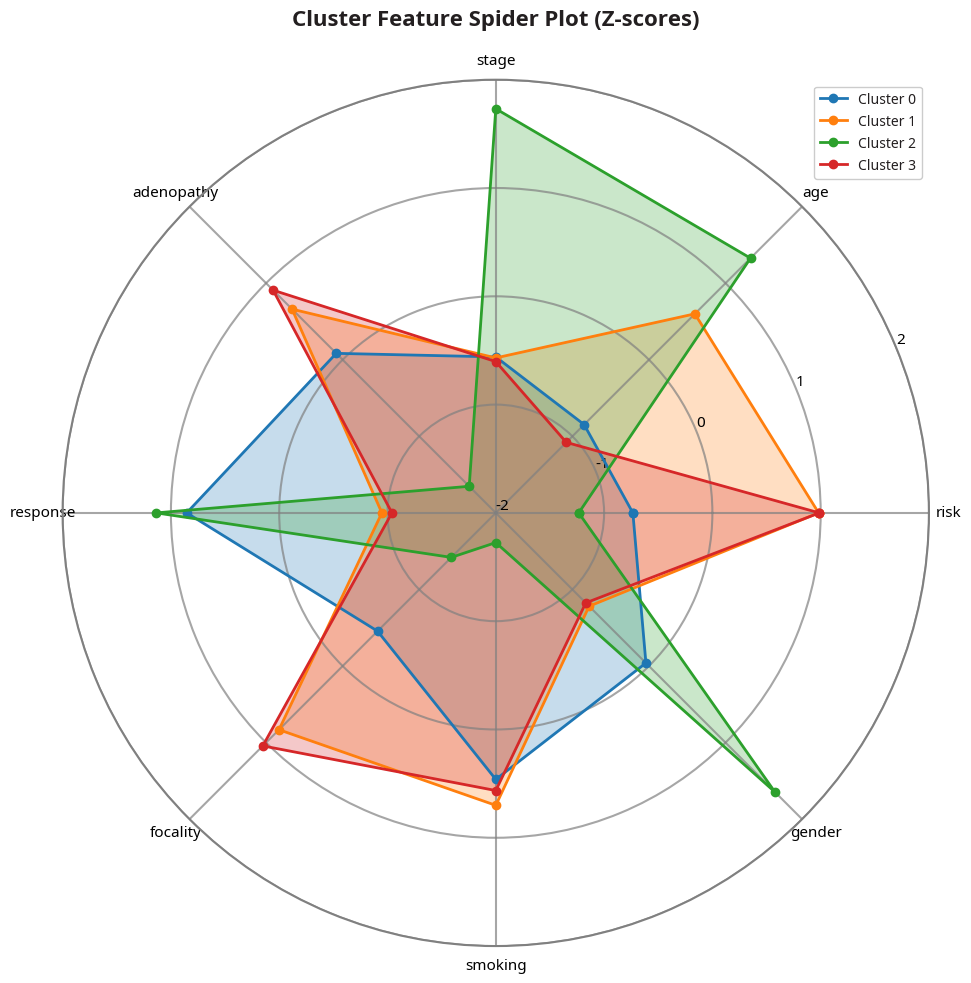

In [11]:
# Select top 8 significant features
top_features = importance_df[importance_df["Significant"] == True].head(8)
top_feature_names = top_features["Feature"].tolist()

# Prepare feature matrix for z-score calculation
feature_matrix = pd.DataFrame()

# Populate feature matrix
for feature in top_feature_names:
    if feature == "age":
        # For continuous variable, use mean age per cluster
        cluster_means = df_clean.groupby("cluster")[feature].mean()
        feature_matrix[feature] = cluster_means
    else:
        # For categorical variables, encode as numeric
        le = LabelEncoder()
        df_clean[f"{feature}_encoded"] = le.fit_transform(df_clean[feature])
        cluster_means = df_clean.groupby("cluster")[f"{feature}_encoded"].mean()
        feature_matrix[feature] = cluster_means

# Calculate z-scores
feature_matrix_z = feature_matrix.apply(zscore, axis=0)

print(feature_matrix_z)

# Prepare for spider plot
categories = top_feature_names
N = len(categories)

# Create angles for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))

# Define colors for each cluster
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
cluster_labels = [f"Cluster {i}" for i in range(4)]

# Plot each cluster
for cluster_id in range(4):
    # Get values for the cluster and repeat the first value to close the circle
    values = feature_matrix_z.loc[cluster_id].values.tolist()
    values += values[:1]

    # Plot data
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=cluster_labels[cluster_id],
        color=colors[cluster_id],
    )
    ax.fill(angles, values, alpha=0.25, color=colors[cluster_id])

# Customize plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(-2, 2)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(["-2", "-1", "0", "1", "2"])
ax.grid(True, linewidth=1.5, alpha=0.7, color="gray", linestyle="-")
ax.spines["polar"].set_linewidth(1.5)
ax.spines["polar"].set_color("gray")
ax.legend()
ax.set_title("Cluster Feature Spider Plot (Z-scores)", size=16, pad=20)
plt.tight_layout()
plt.show()
fig.savefig("../results/figures/cluster_spider_plot.png", dpi=300, bbox_inches="tight")

### 5.3 Pairwise Comparison

     Pair     Feature            Test     Statistic       P-value
0   C0-C1        risk      Chi-square    138.173550  9.908201e-31
1   C0-C1         age  Mann-Whitney U    373.000000  4.488687e-21
2   C0-C1       stage      Chi-square      0.000000  1.000000e+00
3   C0-C1  adenopathy      Chi-square    110.282117  3.571729e-22
4   C0-C1    response      Chi-square     57.540737  1.970042e-12
5   C0-C1    focality      Chi-square     21.865719  2.924113e-06
6   C0-C1     smoking      Chi-square      2.014050  3.653041e-01
7   C0-C1      gender      Chi-square      3.933088  4.734493e-02
8   C0-C2        risk      Chi-square     30.554572  2.318244e-07
9   C0-C2         age  Mann-Whitney U    111.000000  9.432060e-20
10  C0-C2       stage      Chi-square     80.324168  1.487051e-16
11  C0-C2  adenopathy      Chi-square     11.789832  3.778385e-02
12  C0-C2    response      Chi-square      4.668988  1.977032e-01
13  C0-C2    focality      Chi-square     11.089597  8.681335e-04
14  C0-C2 

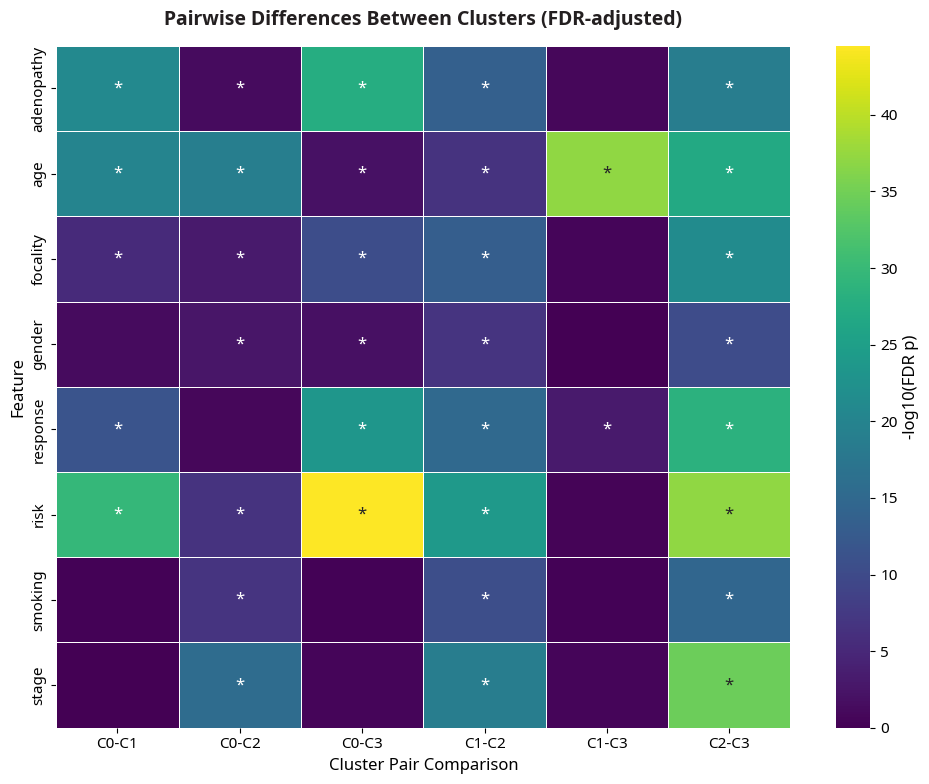

cluster                   
0        Total                 69.000000
         Recurred              45.000000
         No_Recurrence         24.000000
         Recurrence_Rate_%     65.217391
1        Total                 88.000000
         Recurred               8.000000
         No_Recurrence         80.000000
         Recurrence_Rate_%      9.090909
2        Total                 57.000000
         Recurred              47.000000
         No_Recurrence         10.000000
         Recurrence_Rate_%     82.456140
3        Total                169.000000
         Recurred               8.000000
         No_Recurrence        161.000000
         Recurrence_Rate_%      4.733728
Name: recurred, dtype: float64


In [13]:
# Get all cluster pairs
cluster_pairs = list(combinations(range(4), 2))

# Use the same features as in the spider plot
features_to_compare = top_feature_names

# Store results
pairwise_results = []

# Perform pairwise comparisons
for pair in cluster_pairs:
    # Get cluster labels
    cluster_a, cluster_b = pair
    pair_label = f"C{cluster_a}-C{cluster_b}"

    # Compute tests
    for feature in features_to_compare:
        if feature == "age":
            # Mann-Whitney U test for continuous variable
            data_a = df_clean[df_clean["cluster"] == cluster_a][feature]
            data_b = df_clean[df_clean["cluster"] == cluster_b][feature]
            stat, p_val = mannwhitneyu(data_a, data_b, alternative="two-sided")
            test_used = "Mann-Whitney U"
        else:
            # Chi-square test for categorical variables
            contingency = pd.crosstab(
                df_clean[df_clean["cluster"].isin([cluster_a, cluster_b])]["cluster"],
                df_clean[df_clean["cluster"].isin([cluster_a, cluster_b])][feature],
            )
            stat, p_val, dof, expected = chi2_contingency(contingency)
            test_used = "Chi-square"

        # Store results
        pairwise_results.append(
            {
                "Pair": pair_label,
                "Feature": feature,
                "Test": test_used,
                "Statistic": stat,
                "P-value": p_val,
            }
        )

# Convert to DataFrame
pairwise_df = pd.DataFrame(pairwise_results)

print(pairwise_df)

# Apply FDR correction for each feature separately
features_list = pairwise_df["Feature"].unique()
pairwise_df["P-value_adjusted"] = np.nan

# Adjust p-values feature-wise
for feature in features_list:
    mask = pairwise_df["Feature"] == feature
    p_values = pairwise_df.loc[mask, "P-value"].values
    reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")
    pairwise_df.loc[mask, "P-value_adjusted"] = p_adjusted

# Add significance marker
pairwise_df["Significant"] = pairwise_df["P-value_adjusted"] < 0.05

# Save results
pairwise_df.to_csv("../results/tables/pairwise_comparisons.csv", index=False)

# Create heatmap
pivot_data = pairwise_df.pivot(
    index="Feature",
    columns="Pair",
    values="P-value_adjusted",
)

# Transform p-values to log
pivot_data_transformed = -np.log10(pivot_data)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    pivot_data_transformed,
    annot=pairwise_df.pivot(
        index="Feature", columns="Pair", values="Significant"
    ).replace({True: "*", False: ""}),
    fmt="",
    cmap="viridis",
    cbar_kws={"label": "-log10(FDR p)"},
    linewidths=0.5,
    linecolor="white",
    ax=ax,
)
ax.set_title(
    "Pairwise Differences Between Clusters (FDR-adjusted)",
    pad=15,
)
ax.set_xlabel("Cluster Pair Comparison")
ax.set_ylabel("Feature")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()
fig.savefig("../results/figures/pairwise_heatmap.png", dpi=300, bbox_inches="tight")

# Merge recurred status back to clustered data
df_clean['recurred'] = df['recurred']

# Calculate recurrence rates by cluster
recurrence_by_cluster = df_clean.groupby('cluster')['recurred'].apply(
    lambda x: pd.Series({
        'Total': len(x),
        'Recurred': (x == 'Yes').sum(),
        'No_Recurrence': (x == 'No').sum(),
        'Recurrence_Rate_%': (x == 'Yes').sum() / len(x) * 100
    })
).T

print(recurrence_by_cluster)